In [53]:
import numpy as np
import pandas as pd

from datetime import datetime
import graphviz
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

%matplotlib inline

import xgboost as xgb

from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.cross_validation import train_test_split

### Observations:

1. Multivariately, both monotonic constraint = 1 and = -1 work as expected
2. Constraining monotonicity leads to a compatible time duration per boosting iteration **. 
3. Need to be careful when constraining the direction for a non-monotonic variable. This can lead to performance degradation.
4. Observed a code crash "Check failed: (wleft) <= (wright)"

** here time duration = time to reach the early stopping on a validation dataset

### Using the California housing dataset [1] to test Xgboost monotonicity constraint
[1] T. Hastie, R. Tibshirani and J. Friedman, “Elements of Statistical Learning Ed. 2”, Chapter 10.14,  Springer, 2009.

In [54]:
cal_housing = fetch_california_housing()
print cal_housing.feature_names, cal_housing.data.shape

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'] (20640, 8)


In [55]:
# Training, validation, and hold-out testing dataset
X_train, X_valid_test, y_train, y_valid_test = train_test_split(cal_housing.data,
                                                                cal_housing.target,
                                                                test_size=0.5,
                                                                random_state=123)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test,
                                                    y_valid_test,
                                                    test_size=0.5,
                                                    random_state=100)

In [56]:
features = ["MedInc", "AveOccup", "Latitude"] 

feature_ids = [cal_housing.feature_names.index(f) for f in features]
print feature_ids

[0, 5, 6]


In [57]:
dtrain = xgb.DMatrix(X_train[:, feature_ids], label = y_train)
dvalid = xgb.DMatrix(X_valid[:, feature_ids], label = y_valid)

### Train 50 times for both monotonically constrained and not constrained cases and calculate the average speed 

In [58]:
#params = {'max_depth': 2,
#          'eta': 0.5,
#          #'gamma': 0,
#          #'min_child_weight': 10,
#         }

params = {'max_depth': 2,
          'eta': 0.05,
          #'gamma': 0,
          #'min_child_weight': 10,
        }

params['silent'] = 1
params['nthread'] = 2
params['seed'] = 123
params['eval_metric'] = "rmse"

params_no_constr = params.copy()
params_constr = params.copy()

params_constr['updater'] = "grow_monotone_colmaker,prune"
params_constr['monotone_constraints'] = "(1,-1,-1)" 


evallist  = [(dtrain, 'train'), (dvalid, 'eval')]


speed_no_constr = []
speed_constr = []

for i in xrange(50):

    start_time = datetime.now()
    bst_no_constr = xgb.train(params_no_constr, dtrain, num_boost_round = 1000, evals = evallist, early_stopping_rounds = 10, verbose_eval = False)
    end_time = datetime.now()
    #print start_time, end_time
    time_spent_no_constr = end_time - start_time
    speed_no_constr.append(time_spent_no_constr.microseconds * 1.0 / bst_no_constr.best_ntree_limit)


    start_time = datetime.now()
    bst_constr = xgb.train(params_constr, dtrain, num_boost_round = 1000, evals = evallist, early_stopping_rounds = 10, verbose_eval = False)
    end_time = datetime.now()
    #print start_time, end_time
    time_spent_constr = end_time - start_time
    speed_constr.append(time_spent_constr.microseconds * 1.0  / bst_constr.best_ntree_limit)


### Seeing compatible speed with or without monotonicity constraint

In [59]:
print "Average speed without monotonicity constrain: %.1f microseconds per iteration" % np.mean(speed_no_constr)
print "Average speed with monotonicity constrain: %.1f microseconds per iteration" % np.mean(speed_constr)

Average speed without monotonicity constrain: 964.9 microseconds per iteration
Average speed with monotonicity constrain: 861.7 microseconds per iteration


In [17]:
def plot_partial_dependency(bst, X, y, f_id, title):
    
    """
    Scan a specific feature. 
    For each value, get the average prediction of all rows.
    """
    
    X_temp = X.copy()
    
    #x_scan = np.linspace(min(X_temp[:, f_id]), max(X_temp[:, f_id]), 50)
    x_scan = np.linspace(np.percentile(X_temp[:, f_id], 0.1), np.percentile(X_temp[:, f_id], 99.5), 50)
    y_partial = []
    
    for point in x_scan:
        
        X_temp[:, f_id] = point
        
        dpartial = xgb.DMatrix(X_temp[:, feature_ids])
        y_partial.append(np.average(bst.predict(dpartial)))
            
    y_partial = np.array(y_partial)
    
    feature_name = cal_housing.feature_names[f_id]


    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)
    
    ax.plot(x_scan, y_partial, '-', color = 'black', linewidth = 1)
    ax.plot(X[:, f_id], y, 'o', color = 'blue', alpha = 0.02)


    ax.set_xlim(min(x_scan), max(x_scan))
    ax.set_xlabel(feature_name, fontsize = 10)
    
    #ax.set_ylim(min(y_partial) - (max(y_partial) - min(y_partial))*0.2,  
    #            max(y_partial) + (max(y_partial) - min(y_partial))*0.2)
    #ax.set_ylim(0, 4)
    ax.set_ylabel('Partial Dependence', fontsize = 12)

    #plt.show()

    
    
def cal_rmse(y_test, y_pred):
    
    """
    Calculate root-mean-square error
    """
    
    square = (y_test - y_pred) ** 2
    
    return np.sqrt(np.mean(square))

### Partial dependence: no monotonicity constrain

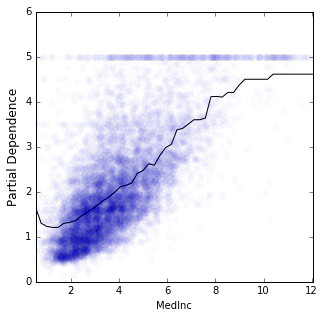

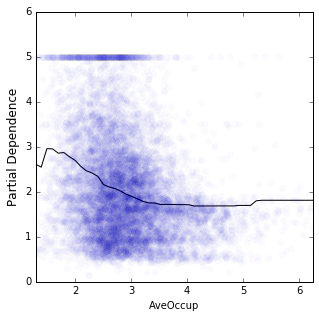

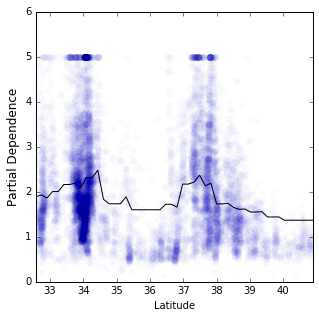

In [61]:
for f_id in feature_ids:
    plot_partial_dependency(bst_no_constr, X_train, y_train, f_id, 'No monotonicity constrain')

### Partial dependence: monotonicity constrain

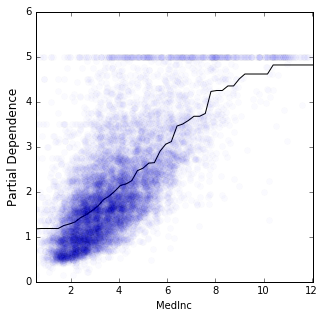

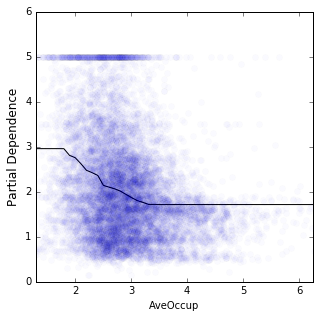

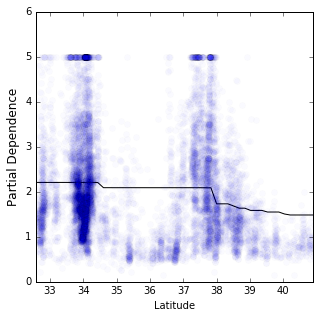

In [62]:
for f_id in feature_ids:
    plot_partial_dependency(bst_constr, X_train, y_train, f_id, 'With monotonicity constrain')

### Constraining direction for a non-monotonic variable (in this case "Latitude") can lead to performance degradation

In [63]:
dtest = xgb.DMatrix(X_test[:, feature_ids])
y_pred_no_constr = bst_no_constr.predict(dtest, ntree_limit = bst_no_constr.best_ntree_limit)
y_pred_constr = bst_constr.predict(dtest, ntree_limit = bst_constr.best_ntree_limit)

print "No monotonicity constraint, testset RMSE: %.4f" % cal_rmse(y_test, y_pred_no_constr)
print "With monotonicity constraint, testset RMSE: %.4f" % cal_rmse(y_test, y_pred_constr)

No monotonicity constraint, testset RMSE: 0.6535
With monotonicity constraint, testset RMSE: 0.7022


### Errors when changing the hyper-parameters?

In [65]:
params = {'max_depth': 3,
          'eta': 0.5,
          #'gamma': 0,
          #'min_child_weight': 10,
        }

params['silent'] = 1
params['nthread'] = 2
params['seed'] = 123
params['eval_metric'] = "rmse"

params_no_constr = params.copy()
params_constr = params.copy()

params_constr['updater'] = "grow_monotone_colmaker,prune"
params_constr['monotone_constraints'] = "(1,-1,-1)" 


evallist  = [(dtrain, 'train'), (dvalid, 'eval')]

bst_constr = xgb.train(params_constr, dtrain, num_boost_round = 1000, evals = evallist, early_stopping_rounds = 10)


[0]	train-rmse:1.1971	eval-rmse:1.19548
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.892963	eval-rmse:0.887115
[2]	train-rmse:0.775522	eval-rmse:0.770932
[3]	train-rmse:0.734062	eval-rmse:0.727709
[4]	train-rmse:0.716208	eval-rmse:0.706151
[5]	train-rmse:0.707742	eval-rmse:0.697331
[6]	train-rmse:0.704203	eval-rmse:0.692863
[7]	train-rmse:0.701585	eval-rmse:0.691155
[8]	train-rmse:0.700708	eval-rmse:0.69027
[9]	train-rmse:0.70009	eval-rmse:0.689879
[10]	train-rmse:0.699778	eval-rmse:0.689667
[11]	train-rmse:0.699335	eval-rmse:0.68896
[12]	train-rmse:0.699029	eval-rmse:0.688458


XGBoostError: [15:15:48] src/tree/./param.h:365: Check failed: (wleft) <= (wright) 